In [2]:
# @title: imports, and graphics setup
import sys
sys.path.append('..')
from multiprocessing import Pool, TimeoutError
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import numpy as np
import mpmath as mp
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import integrate as integrate
from Modules.potential_operations import histogram_potential_fitter, normalized_pdf_from_potential, generate_theoretical_pdf_for_fit
from Modules.custom_simulations import simulate_particles_in_external_force_Not_HOOMD
import warnings
from scipy.optimize import fsolve
from tqdm.auto import tqdm, trange
from Modules.pdfs import *
from joblib import Parallel, delayed
import re

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

In [3]:
from Modules.potentials import harmonic_potential
from Modules.forces import harmonic_force

In [4]:
def run_simulation(n_particles, steps, x_start_position, force ,force_args, delta_fraction,dt, kT, gamma):
    start_position=x_start_position
    args = [force, n_particles, steps, delta_fraction]
    trajectories = simulate_particles_in_external_force_Not_HOOMD(*args, dt=dt, kT=kT, force_args=force_args, start_position=start_position, gamma=gamma, type=np.float32)
    x_positions = np.array(trajectories)
    return x_positions

## r $\neq$ 0

In [17]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 16000
batch_size = 8000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]

typical_relaxation_time = gamma/k_harm
print(typical_relaxation_time)

typical_length_scale = np.sqrt(D*typical_relaxation_time)
print(typical_length_scale)
### resetting parameters ### 
delta_fraction = 0.002
resetting_rate = delta_fraction/dt
start_positions = np.linspace(np.floor(-10*typical_length_scale), 0, 11)[::-1]
print(start_positions/typical_length_scale)

start_positions_str = [f'{abs(x):.2f}'[:] for x in start_positions]
start_positions_str = ','.join(start_positions_str)
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
print('Folder -', folder)

100.0
0.4472135954999579
[  0.          -1.11803399  -2.23606798  -3.35410197  -4.47213595
  -5.59016994  -6.70820393  -7.82623792  -8.94427191 -10.0623059
 -11.18033989]
Folder - HarmonicPotentialTrajectories/x_0-0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00


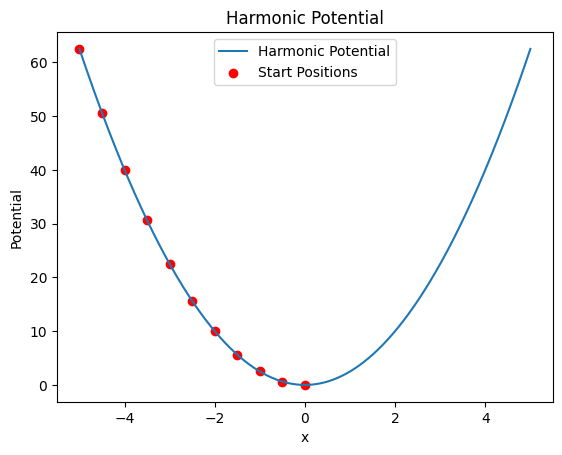

In [18]:
### plot potential ###
potential_x = np.linspace(-5, 5, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y, label='Harmonic Potential')
plt.scatter(start_positions, harmonic_potential(np.array(start_positions), k_harm)/kT, color='red', label='Start Positions')
plt.title('Harmonic Potential')
plt.xlabel('x')
plt.ylabel('Potential')
plt.legend()
plt.show()

In [19]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","b","y","y","orange","orange","orange","r","r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(np.abs(start_positions)),vmax=max(np.abs(start_positions)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

colors = [cpick.to_rgba(np.abs(start_pos)) for start_pos in start_positions]

In [21]:
### Run simulations ###
#raise KeyboardInterrupt
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
os.makedirs(folder, exist_ok=True)
filenames = os.listdir(folder)
existing_batches = 0
for file in filenames:
    if re.search("^batch.*npy", file):
        nums = re.findall((r'\d+'), file)
        n = ''.join(nums)
        if int(n) > existing_batches:
            existing_batches = int(n)
print("Existing Batches: ", existing_batches)
if __name__ == "__main__":
    for _ in np.arange(0 , n_particles, batch_size):
        print(_)
        simulation_parameters = [(batch_size, steps, start_pos, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for start_pos in start_positions]
        trajectories_per_start = Parallel(n_jobs=-2, verbose = 1, backend='loky')(delayed(run_simulation)(*args) for args in simulation_parameters)
        np.save(folder+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_start)
        print(f'Finished {_+batch_size} particles')
    print('Finished all particles')

[0, 8000]
Existing Batches:  0
0


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  11 out of  11 | elapsed:    8.2s finished


Finished 8000 particles
8000


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  11 out of  11 | elapsed:    6.3s finished


Finished 16000 particles
Finished all particles


In [22]:
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
filenames = os.listdir(folder)
trajectories = np.load(folder+'/'+filenames[0])
trajectories_per_start = np.array(trajectories)

(0.0, 3000.0)

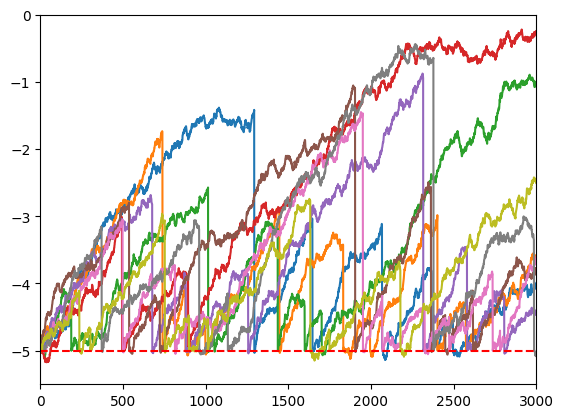

In [23]:
plt.plot(np.arange(steps), trajectories_per_start[-1, :, 1:10])
plt.axhline(y = -5, color='r', linestyle='--')
plt.ylim(-5.5, -0)
plt.xlim(0, 3000)

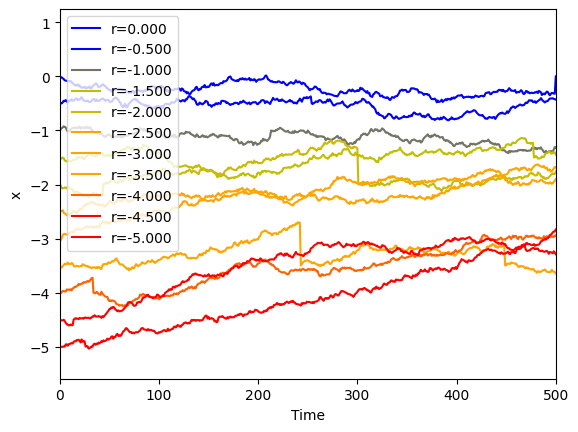

In [24]:
### plot trajectories ###
for i, [rate, trajs] in enumerate(zip(start_positions, trajectories_per_start)):
    plt.plot(np.arange(steps), trajs[:, 0], label=f'r={rate:.3f}', color=colors[i])
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.xlim(0, 500)
plt.show()

In [29]:
def _calculate_single_mean_var(x_pos):
    mean = np.mean(x_pos, axis=1)
    var = np.var(x_pos, axis=1)
    return mean, var

def calculate_mean_var_trajectory_per_k(trajs):
    means_vars_per_pos = []
    for x_pos in trajs:
        means_vars_per_pos.append(_calculate_single_mean_var(x_pos))
    return np.array(means_vars_per_pos)

def calculate_average_measure_per_batches(folder, measure, batches=-1, args=[]):
    if batches == 0:
        return None
    c = 0
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                value = measure(trajectories_per_r, *args)
            else:
                value += measure(trajectories_per_r, *args)
            c+=1
            if batches != -1 and batches == c:
                break
            del trajectories_per_r
            print(f'finished batch {c} of {batches}')
    return value/c

In [30]:
means_vars = calculate_average_measure_per_batches(folder, calculate_mean_var_trajectory_per_k, batches=3)
means = means_vars[:, 0]
vars = means_vars[:, 1]
del means_vars

finished batch 1 of 3
finished batch 2 of 3


In [31]:
np.save(folder+'/mean_trajectories.npy', means)
np.save(folder+'/var_trajectories.npy', vars)

In [32]:
means = np.load(folder+'/mean_trajectories.npy')
vars = np.load(folder+'/var_trajectories.npy')

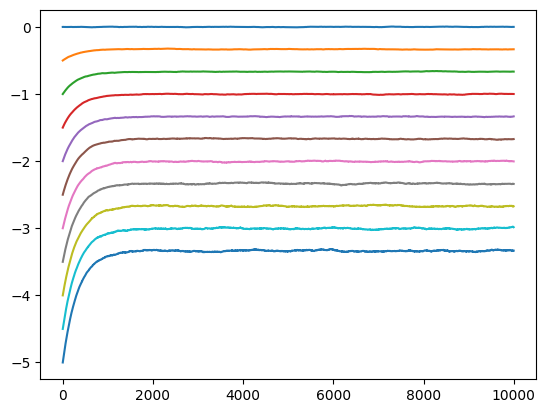

In [33]:
### plot mean per start ### 
for start_pos,mean_traj in zip(start_positions,means):
    plt.plot(mean_traj)
plt.show()

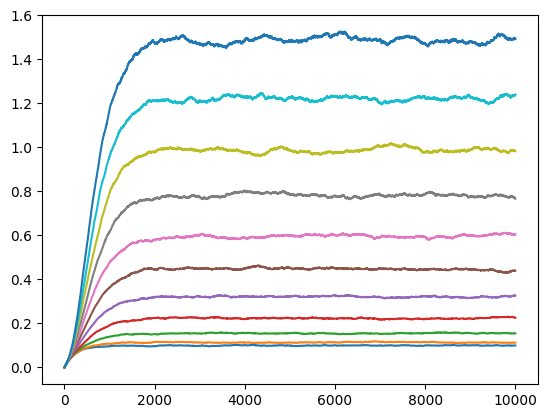

In [34]:
### plot var per start ### 
for start_pos,var_traj in zip(start_positions,vars):
    plt.plot(var_traj)
plt.show()

In [35]:
### Histograms using the same bins NO BATCHES ###

def _calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_timestep = []
    target_distribution_points = x_pos[-n_target_distribution_samples:]
    target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
    for timestep in timesteps:
        if timestep != 0:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
        else:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histograms_per_timestep.append([histogram, bin_centers])
    histograms_per_timestep.append([target_distribution, bin_centers])
    return histograms_per_timestep

def generate_histograms_per_start(trajs, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_rate = Parallel(n_jobs=-1, prefer='threads')(delayed(_calculate_single_histogram)(x_pos, bins, timesteps, n_samples, n_target_distribution_samples) for x_pos in trajs)
    histograms_per_rate = np.array(histograms_per_rate)
    return histograms_per_rate

In [36]:
### Histograms using the same bins NO BATCHES ###

samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, samples)
histograms_per_start_pos = []
min_bin = np.min(trajectories_per_start[-1][-samples:])
max_bin = np.max(trajectories_per_start[0][-samples:])
bin_edges = np.linspace(min_bin, max_bin, 201)
bins = bin_edges*1.2

In [37]:
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
c = 0
for filename in os.listdir(folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        trajectories = np.load(folder+'/'+filename)
        trajs = np.array(trajectories) 
        if c == 0:
            histograms_per_start_pos = generate_histograms_per_start(trajs, bins, timesteps, samples, target_distribution_samples)
        else:
            histograms_per_start_pos += generate_histograms_per_start(trajs, bins, timesteps, samples, target_distribution_samples)
        c+=1
histograms_per_start_pos = histograms_per_start_pos/c

In [38]:
np.save(folder+'/histograms_per_start_pos.npy', histograms_per_start_pos)

In [39]:
histograms_per_start_pos = np.load(folder+'/histograms_per_start_pos.npy')

0.9999946416525638
0.999996847311423
0.9999999807220978
0.9999960016043113
0.9999999971482049
1.000000058952188
1.0000000367213167
0.9999997607202515
0.9999999692232607
1.0000000055604834
1.0000000046192108


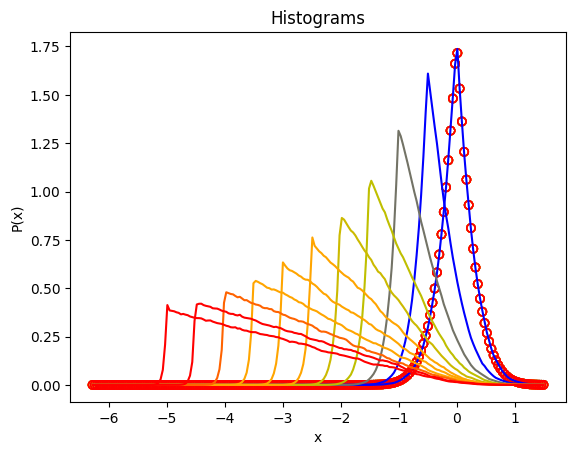

In [40]:
### plot histograms at ss ###
for i, (histograms_per_time, start_pos, c) in enumerate(zip(histograms_per_start_pos, start_positions, colors)):
    hist, bin_centers = histograms_per_time[-1]
    bin_centers_centralized = bin_centers - np.mean(bin_centers)
    print(np.trapezoid(hist, bin_centers))
    plt.plot(bin_centers, hist, label=f'{start_positions[i]:.3f}', color=c)
    if start_pos == 0:
        pdf = lambda x: pdf_resetting_in_harmonic_potential(x, k_harm, resetting_rate*dt, shift=0, dt=dt, kT=kT, gamma=gamma)
    plt.scatter(bin_centers, pdf(bin_centers), label=f'{start_pos:.3f}', color=c, marker='o', facecolors='none')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('Histograms')
plt.show()

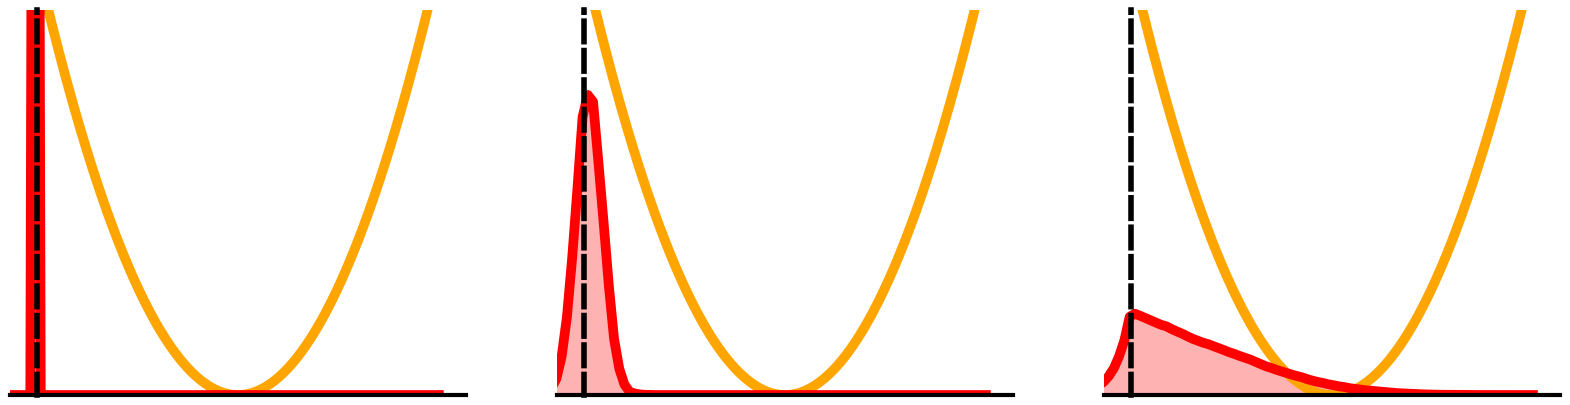

In [41]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()
color='r'
offset_histograms = histograms_per_start_pos[3]
for i in range(3):
    if i == 0:
        hist, bin_centers = offset_histograms[0]
        xlim = (-1.7, 1.7)
        ylim = (0, 5)
    elif i == 1:
        hist, bin_centers = offset_histograms[5]
        xlim = (-1.7, 1.7)
        ylim = (0, 5)
    else:
        hist, bin_centers = offset_histograms[-1]
        xlim = (-1.7, 1.7)
        ylim = (0, 5)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', start_positions[3]), lw=4,linestyle='--')
    axs[i].spines['bottom'].set(lw=3)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=7, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=7, zorder=1)
    axs[i].set_xlim(*xlim)
    axs[i].set_ylim(*ylim)
figname = 'a - Resetting PDF Relaxation - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure2',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

[ 0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5 -5. ]


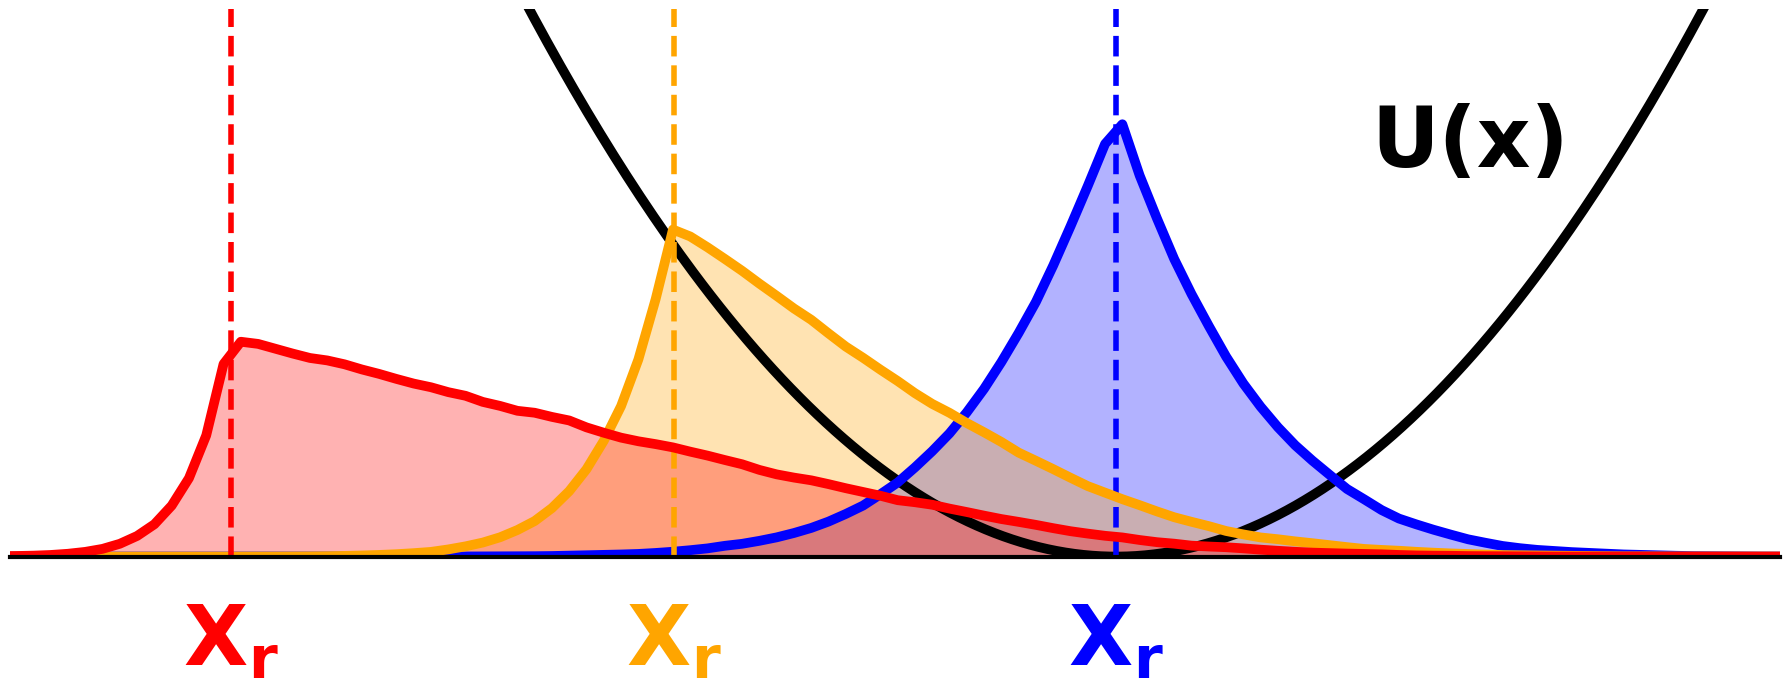

In [42]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
xlim = (-2.5, 1.5)
ylim = (0, 2.2)
print(start_positions)
positions_to_print = [0, -1, -2]
for i , (hists, color) in enumerate(zip(histograms_per_start_pos, colors)):
    if start_positions[i] not in positions_to_print:
        continue
    if start_positions[i] == positions_to_print[-1]:
        color = 'red'
    elif start_positions[i] == positions_to_print[0]:
        color = 'blue'
    elif start_positions[i] == positions_to_print[1]:
        color = 'orange'
    ss_hist, ss_bin_centers = hists[-1]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set(lw=3)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(start_positions[i], -0.5, '$\\bf{X_r}$', fontsize=60, ha='center', va='bottom', color=color, weight='heavy')
    ax.axvline(start_positions[i], color=color, linestyle='--', lw=4)
    ax.plot(ss_bin_centers, ss_hist,color=color, linewidth=7, zorder=2)
    ax.fill_between(ss_bin_centers, ss_hist, alpha=0.3, color=color)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
ax.plot(potential_x, potential_y*0.5, label='U(x)', color='Black', linewidth=7, zorder=1)
ax.text(0.8, 1.5, 'U(x)', fontsize=60, ha='center', va='bottom', color='Black', weight='heavy')
start_positions_handle = [plt.Line2D([0], [0], color='black', linewidth=4, linestyle='--', label='Resetting Position')]
potential_handle = [plt.Line2D([0], [0], color='Orange', linewidth=7, label='U(x)')]
plt.tight_layout()
figname = 'a - Resetting PDF for different x_0 - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure2',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

In [43]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [44]:
total_batches = 0
for filename in os.listdir(folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        total_batches += 1
print('Total Batches: ', total_batches)

Total Batches:  2


In [46]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
histograms_per_BST = [] #Batch Start Time
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, samples)
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
for i in tqdm(range(total_batches)):
    histograms_per_ST = []
    for filename in os.listdir(folder):
        check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        if check_if_batch_file and batch_found == str(i+1):
            trajectories = np.load(folder+'/'+filename)
            trajectories_per_start = np.array(trajectories)
            del trajectories
            break
    histograms_per_ST = generate_histograms_per_start(trajectories_per_start, bins, timesteps, samples, target_distribution_samples)
    del trajectories_per_start
    histograms_per_BST.append(histograms_per_ST)
    print(f'Finished batch {i+1} of {total_batches}')
histograms_per_BST = np.array(histograms_per_BST)
np.save(folder+'/histograms_per_BST.npy', histograms_per_BST)

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\nir19\AppData\Local\Temp\ipykernel_548\1140586853.py:11: SyntaxWarning: invalid escape sequence '\.'
  check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None


  0%|          | 0/2 [00:00<?, ?it/s]

Finished batch 1 of 2
Finished batch 2 of 2


In [47]:
### Calculate KLDs per rate ###
#raise KeyboardInterrupt
KLDs_per_BS = []
for i, histograms_per_ST in tqdm(enumerate(histograms_per_BST)):
    KLDs_per_S = []
    for histograms_per_time, start_pos in zip(histograms_per_ST, start_positions):
        KLDs_by_TS = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_TS.append(kld)
        


        KLDs_by_TS = np.array(KLDs_by_TS)
        nans, x = nan_helper(KLDs_by_TS)
        if np.sum(nans) != 0:
            KLDs_by_TS[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TS)[~nans])
        KLDs_per_S.append(KLDs_by_TS)
    KLDs_per_S = np.array(KLDs_per_S)
    KLDs_per_BS.append(KLDs_per_S)
KLDs_per_BS = np.array(KLDs_per_BS)
np.save(folder+f'/KLDs_per_BS.npy', KLDs_per_BS)

0it [00:00, ?it/s]

In [48]:
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, samples)
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
KLDs_per_BS = np.load(folder+f'/KLDs_per_BS.npy')

(2, 11, 1400)
(11, 1400)


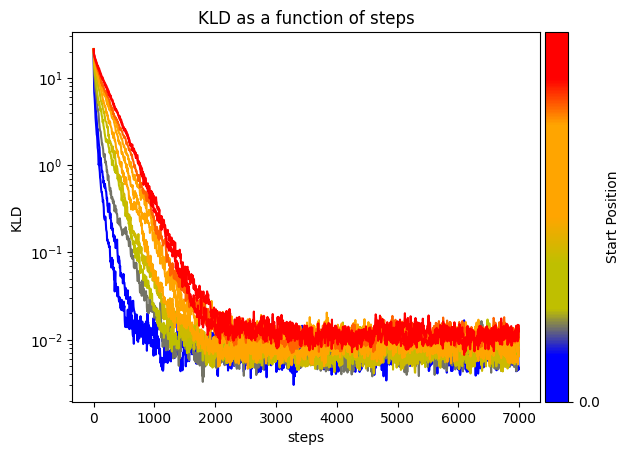

In [49]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable


print(KLDs_per_BS.shape)
KLDs_per_start = np.mean(KLDs_per_BS, axis=0)
print(KLDs_per_start.shape)
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
for kld_per_time, start_pos, c in zip(KLDs_per_start, start_positions, colors):
    im = ax.semilogy(timesteps,kld_per_time, label=f'{start_pos:.3f}', color=c)
fig.colorbar(cpick, cax=cax, label='Start Position', ticks=start_positions)
ax.set_xlabel('steps')
ax.set_ylabel('KLD')
ax.set_title('KLD as a function of steps')
plt.show()

In [50]:
# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","b","y","y","orange","orange","orange","r","r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
normalized_start_positions = np.array(start_positions)/typical_length_scale
cnorm_normlized = mcol.Normalize(vmin=min(np.abs(normalized_start_positions)),vmax=max(np.abs(normalized_start_positions)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick_normlized = cm.ScalarMappable(norm=cnorm_normlized,cmap=cm1)

colors_normlized = [cpick_normlized.to_rgba(np.abs(start_pos)) for start_pos in normalized_start_positions]
print(normalized_start_positions)

[  0.          -1.11803399  -2.23606798  -3.35410197  -4.47213595
  -5.59016994  -6.70820393  -7.82623792  -8.94427191 -10.0623059
 -11.18033989]


KLD Threshold: 0.04268151539426252
KLD Threshold: 0.04004110998033453


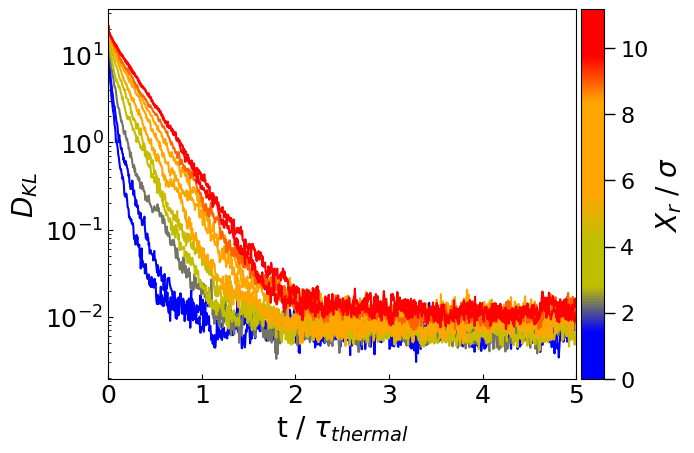

In [54]:

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
timesteps = np.arange(0, steady_state, 5)

platue_indices_per_r = []
for klds_per_batch in KLDs_per_BS:
    platue_index_per_r = []
    kld_thresholds = []
    kld_thresholds = np.mean(klds_per_batch[:, -50:], axis=1)
    std_kld_thresholds = np.std(klds_per_batch[:, -50:], axis=1)
    kld_thresholds = kld_thresholds + 10*std_kld_thresholds
    kld_threshold = np.max(kld_thresholds)
    print('KLD Threshold:', kld_threshold)
    for kld_per_time, r, c in zip(klds_per_batch, normalized_start_positions, colors_normlized):
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]
        platue_index_per_r.append(timestep_platue)
    platue_indices_per_r.append(platue_index_per_r)
platue_indices_per_r = np.array(platue_indices_per_r)
mean_platue_indices_per_r = np.mean(platue_indices_per_r, axis=0)*dt/typical_relaxation_time
std_platue_indices_per_r = np.std(platue_indices_per_r, axis=0)*dt/typical_relaxation_time
for kld_per_time, platue, s, c in zip(KLDs_per_start, mean_platue_indices_per_r, start_positions, colors_normlized):
    im=ax.semilogy(timesteps*dt/typical_relaxation_time,kld_per_time, label=f'{r:.3f}', color=c)
    #im=ax.axvline(platue, color=c, linestyle='--')
cbar = fig.colorbar(cpick_normlized, cax=cax, label='Resetting Position', orientation='vertical',ticklocation='right')
cbar.ax.tick_params(labelsize=16, direction='out', length=8, width=1)
cbar.ax.set_ylabel('$X_r$ / $\\sigma$', fontsize=20)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for s, c in zip(start_positions, colors_normlized):
    h = plt.bar([0],[0],color=c,label=f'$x_0$={r:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{thermal}$ ', fontsize=20)
ax.set_ylabel('$D_{KL}$',fontsize=20)
ax.set_xlim(0, 5)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
figname = 'b - KLD by steps - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure2',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

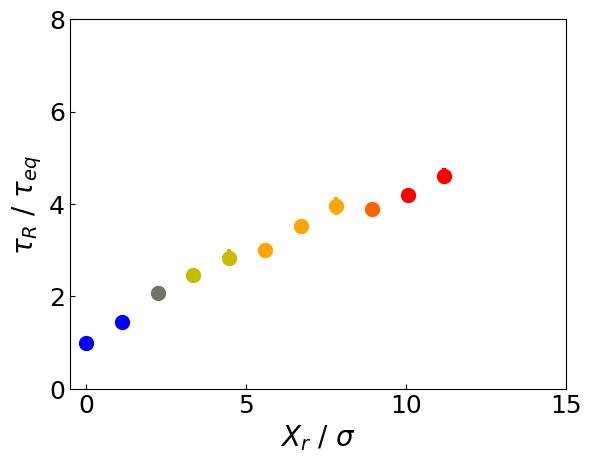

In [55]:
for i, r in enumerate(start_positions):
    plt.errorbar(-1*start_positions[i]/typical_length_scale, mean_platue_indices_per_r[i]/mean_platue_indices_per_r[0], yerr=std_platue_indices_per_r[i]/mean_platue_indices_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=colors_normlized[i])
plt.xlabel('$X_r$ / $\\sigma$', fontsize=20)
plt.ylabel('$\\tau_R$ / $\\tau_{eq}$ ', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.xlim(-0.5, 15)
plt.ylim(0, 8)
figname = 'c - Relaxation by resetting rate - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure2',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

In [56]:
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
np.save(folder+f'/mean_platue_indices_per_K.npy', mean_platue_indices_per_r)
np.save(folder+f'/std_platue_indices_per_K.npy', std_platue_indices_per_r)
np.save(folder+f'/start_positions.npy', -1*start_positions/typical_length_scale)

In [57]:
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
mean_platue_indices_per_r = np.load(folder+f'/mean_platue_indices_per_K.npy')
std_platue_indices_per_r = np.load(folder+f'/std_platue_indices_per_K.npy')


## r = 0

In [8]:

### Simulation Parameters ###
dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 16000
batch_size = 8000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]

typical_relaxation_time = gamma/k_harm
print(typical_relaxation_time)

typical_length_scale = np.sqrt(D*typical_relaxation_time)
print(typical_length_scale)

### resetting parameters ### 
delta_fraction = 0
resetting_rate = delta_fraction/dt
start_positions = np.linspace(np.floor(-10*typical_length_scale), 0, 11)[::-1]
trajectories_per_start_boltz = None
start_positions_str = [f'{abs(x):.2f}'[:] for x in start_positions]
start_positions_str = ','.join(start_positions_str)
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
print('Folder -', folder)

100.0
0.4472135954999579
Folder - HarmonicPotentialTrajectories/x_0_r_0-0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00


In [ ]:
### Run simulations ###
#raise KeyboardInterrupt
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
os.makedirs(folder, exist_ok=True)
filenames = os.listdir(folder)
existing_batches = 0
for file in filenames:
    if re.search("^batch.*npy", file):
        nums = re.findall((r'\d+'), file)
        n = ''.join(nums)
        if int(n) > existing_batches:
            existing_batches = int(n)
print("Existing Batches: ", existing_batches)
if __name__ == "__main__":
    for _ in np.arange(0 , n_particles, batch_size):
        simulation_parameters = [(batch_size, steps, start_pos, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for start_pos in start_positions]
        trajectories_per_start_boltz = Parallel(n_jobs=-2, verbose = 0, backend='loky')(delayed(run_simulation)(*args) for args in simulation_parameters)
        np.save(folder+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_start_boltz)
        print(f'Finished {_+batch_size} particles')
    print('Finished all particles')


[0, 8000]
Existing Batches:  0
Finished 8000 particles
Finished 16000 particles
Finished all particles


In [6]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","b","y","y","orange","orange","orange","r","r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(np.abs(start_positions)),vmax=max(np.abs(start_positions)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

colors = [cpick.to_rgba(np.abs(start_pos)) for start_pos in start_positions]

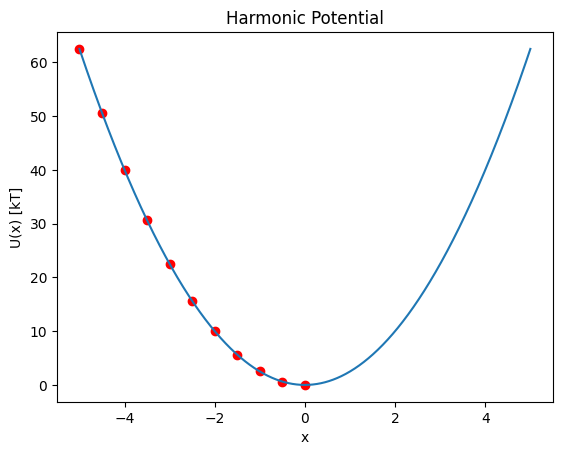

In [7]:
### plot potential ###
potential_x = np.linspace(-5, 5, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y)
plt.scatter(start_positions, harmonic_potential(np.array(start_positions), k_harm)/kT, color='red')
plt.xlabel('x')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

In [9]:
c = 0
if trajectories_per_start_boltz is None:
    filenames = os.listdir(folder)
    trajectories = np.load(folder+'/'+filenames[0])
    trajectories_per_start_boltz = np.array(trajectories)
    del trajectories
else:
    print('Using existing trajectories_per_start')


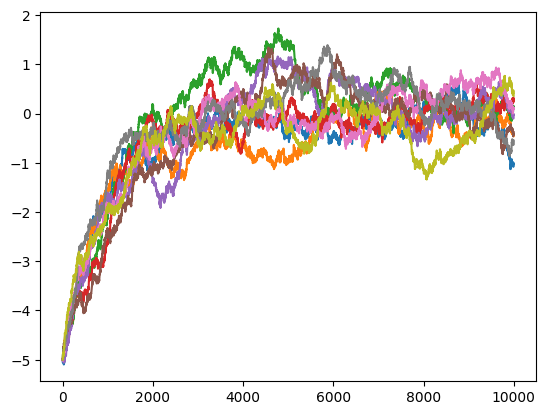

In [10]:
plt.plot(np.arange(steps), trajectories_per_start_boltz[-1, :, 1:10])
plt.show()

In [11]:
def _calculate_single_mean_var(x_pos):
    mean = np.mean(x_pos, axis=1)
    var = np.var(x_pos, axis=1)
    return mean, var

def calculate_mean_var_trajectory_per_k(trajs):
    means_vars_per_pos = []
    for x_pos in trajs:
        means_vars_per_pos.append(_calculate_single_mean_var(x_pos))
    return np.array(means_vars_per_pos)

def calculate_average_measure_per_batches(folder, measure, batches=-1, args=[]):
    if batches == 0:
        return None
    c = 0
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                value = measure(trajectories_per_r, *args)
            else:
                value += measure(trajectories_per_r, *args)
            c+=1
            if batches != -1 and batches == c:
                break
            del trajectories_per_r
            print(f'finished batch {c} of {batches}')
    return value/c

In [12]:
means_vars = calculate_average_measure_per_batches(folder, calculate_mean_var_trajectory_per_k, batches=3)
means_boltz = means_vars[:, 0]
vars_boltz = means_vars[:, 1]
del means_vars

finished batch 1 of 3
finished batch 2 of 3


In [13]:
np.save(folder+'/mean_trajectories.npy', means_boltz)
np.save(folder+'/var_trajectories.npy', vars_boltz)

In [14]:
means_boltz = np.load(folder+'/mean_trajectories.npy')
vars_boltz = np.load(folder+'/var_trajectories.npy')

Text(0, 0.5, 'x')

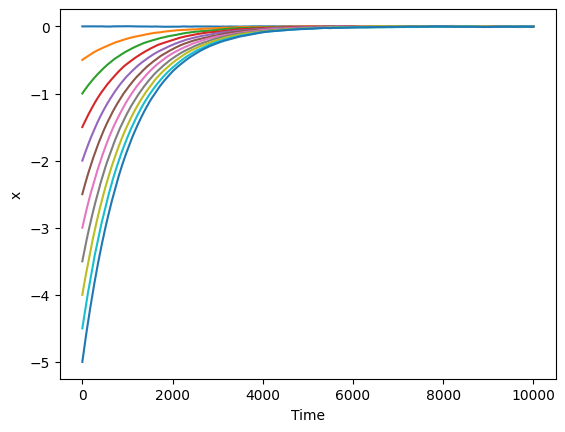

In [15]:
for i, s in enumerate(start_positions):
    plt.plot(means_boltz[i])
plt.xlabel('Time')
plt.ylabel('x')

Text(0, 0.5, 'x')

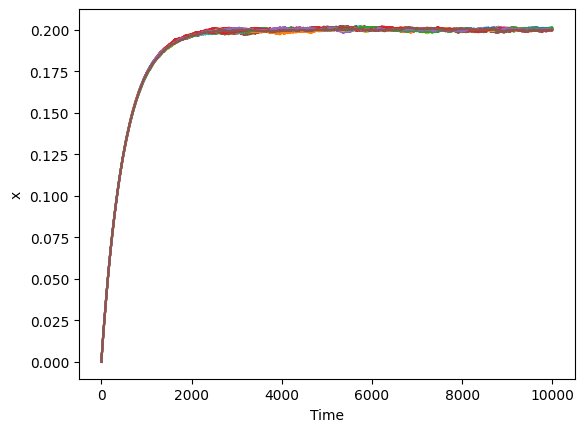

In [23]:
for i, s in enumerate(start_positions):
    plt.plot(vars_boltz[i])
plt.xlabel('Time')
plt.ylabel('x')

In [16]:
### Histograms using the same bins NO BATCHES ###
def _calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_timestep = []
    target_distribution_points = x_pos[-n_target_distribution_samples:]
    target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
    for timestep in timesteps:
        if timestep != 0:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
        else:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histograms_per_timestep.append([histogram, bin_centers])
    histograms_per_timestep.append([target_distribution, bin_centers])
    return histograms_per_timestep

def generate_histograms_per_start(trajs, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_rate = Parallel(n_jobs=-1, prefer='threads')(delayed(_calculate_single_histogram)(x_pos, bins, timesteps, n_samples, n_target_distribution_samples) for x_pos in trajs)
    histograms_per_rate = np.array(histograms_per_rate)
    return histograms_per_rate

In [17]:
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 5)
histograms_per_start_pos = []
min_bin = np.min(trajectories_per_start_boltz[-1][-samples:])
max_bin = np.max(trajectories_per_start_boltz[0][-samples:])
bin_edges = np.linspace(min_bin, max_bin, 201)
bins = bin_edges*1.2

In [18]:
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
c = 0
for filename in os.listdir(folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        trajectories = np.load(folder+'/'+filename)
        trajs = np.array(trajectories) 
        if c == 0:
            histograms_per_start_pos_boltz = generate_histograms_per_start(trajs, bins, timesteps, samples, target_distribution_samples)
        else:
            histograms_per_start_pos_boltz += generate_histograms_per_start(trajs, bins, timesteps, samples, target_distribution_samples)
        c+=1
histograms_per_start_pos_boltz = histograms_per_start_pos_boltz/c

c:\Users\nir19\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [19]:
np.save(folder+'/histograms_per_start_pos_boltz.npy', histograms_per_start_pos_boltz)

In [20]:
histograms_per_start_pos_boltz = np.load(folder+'/histograms_per_start_pos_boltz.npy')

1.0000000045580026
1.0000000038737271
0.9999995688678135
0.9999978785215092
0.999998755113483
0.9999995063177282
1.0000000052461064
0.9999993789582513
1.0000000053113052
0.9999995044999833
1.000000005005236


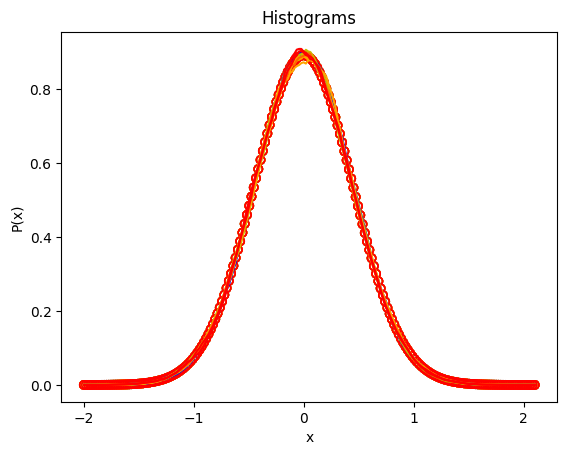

In [21]:
### plot histograms at ss ###
for i, (histograms_per_time, start_pos, c) in enumerate(zip(histograms_per_start_pos_boltz, start_positions, colors)):
    hist, bin_centers = histograms_per_time[-1]
    bin_centers_centralized = bin_centers - np.mean(bin_centers)
    print(np.trapezoid(hist, bin_centers))
    plt.plot(bin_centers, hist, label=f'{start_positions[i]:.3f}', color=c)
    pdf = pdf_harmonic_boltzmann(k=k_harm ,kT=kT)
    plt.scatter(bin_centers, pdf(bin_centers), label=f'{start_pos:.3f}', color=c, marker='o', facecolors='none')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('Histograms')
plt.show()

In [22]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [23]:
total_batches = 0
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
for filename in os.listdir(folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        total_batches += 1
print('Total Batches: ', total_batches)

Total Batches:  2


In [24]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
histograms_per_BST_boltz = [] #Batch Start Time
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 5)
for i in tqdm(range(total_batches)):
    histograms_per_ST = []
    for filename in os.listdir(folder):
        check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        if check_if_batch_file and batch_found == str(i+1):
            trajectories = np.load(folder+'/'+filename)
            trajectories_per_start = np.array(trajectories)
            del trajectories
            break
    histograms_per_ST = generate_histograms_per_start(trajectories_per_start, bins, timesteps, samples, target_distribution_samples)
    del trajectories_per_start
    histograms_per_BST_boltz.append(histograms_per_ST)
    print(f'Finished batch {i+1} of {total_batches}')
histograms_per_BST_boltz = np.array(histograms_per_BST_boltz)
np.save(folder+'/histograms_per_BST_boltz.npy', histograms_per_BST_boltz)

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\nir19\AppData\Local\Temp\ipykernel_30200\532670671.py:11: SyntaxWarning: invalid escape sequence '\.'
  check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None


  0%|          | 0/2 [00:00<?, ?it/s]

Finished batch 1 of 2
Finished batch 2 of 2


In [25]:
### Calculate KLDs per rate ###
#raise KeyboardInterrupt
KLDs_per_BS_boltz = []
for i, histograms_per_ST in tqdm(enumerate(histograms_per_BST_boltz)):
    KLDs_per_S = []
    for histograms_per_time, start_pos in zip(histograms_per_ST, start_positions):
        KLDs_by_TS = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_TS.append(kld)
        
        KLDs_by_TS = np.array(KLDs_by_TS)
        nans, x = nan_helper(KLDs_by_TS)
        if np.sum(nans) != 0:
            KLDs_by_TS[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TS)[~nans])
        KLDs_per_S.append(KLDs_by_TS)
    KLDs_per_S = np.array(KLDs_per_S)
    KLDs_per_BS_boltz.append(KLDs_per_S)
KLDs_per_BS_boltz = np.array(KLDs_per_BS_boltz)
np.save(folder+f'/KLDs_per_BS_boltz.npy', KLDs_per_BS_boltz)

0it [00:00, ?it/s]

In [26]:
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 5)
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
KLDs_per_BS_boltz = np.load(folder+f'/KLDs_per_BS_boltz.npy')

(2, 11, 1400)
(11, 1400)


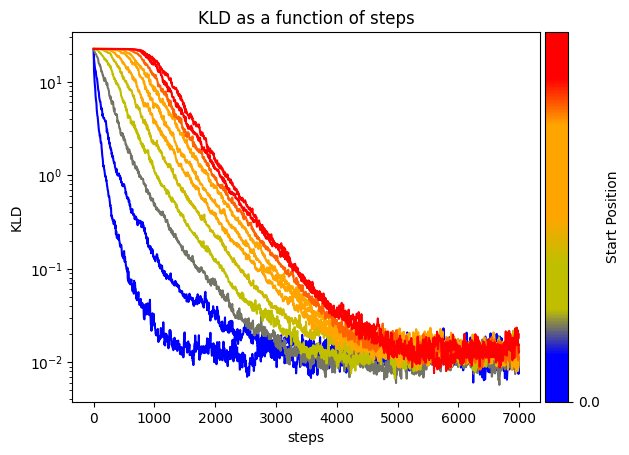

In [27]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable


print(KLDs_per_BS_boltz.shape)
KLDs_per_start = np.mean(KLDs_per_BS_boltz, axis=0)
print(KLDs_per_start.shape)
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
for kld_per_time, start_pos, c in zip(KLDs_per_start, start_positions, colors):
    im = ax.semilogy(timesteps,kld_per_time, label=f'{start_pos:.3f}', color=c)
fig.colorbar(cpick, cax=cax, label='Start Position', ticks=start_positions)
ax.set_xlabel('steps')
ax.set_ylabel('KLD')
ax.set_title('KLD as a function of steps')
plt.show()

In [28]:
# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","b","y","y","orange","orange","orange","r","r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
normalized_start_positions = np.array(start_positions)/typical_length_scale
cnorm_normlized = mcol.Normalize(vmin=min(np.abs(normalized_start_positions)),vmax=max(np.abs(normalized_start_positions)))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick_normlized = cm.ScalarMappable(norm=cnorm_normlized,cmap=cm1)

colors_normlized = [cpick_normlized.to_rgba(np.abs(start_pos)) for start_pos in normalized_start_positions]
print(normalized_start_positions)


[  0.          -1.11803399  -2.23606798  -3.35410197  -4.47213595
  -5.59016994  -6.70820393  -7.82623792  -8.94427191 -10.0623059
 -11.18033989]


KLD Threshold: 0.06014430274552819
KLD Threshold: 0.06042198457322048


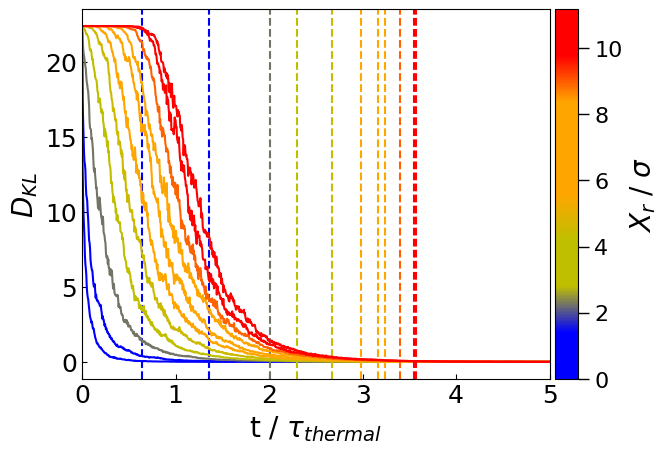

In [30]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
timesteps = np.arange(0, steady_state, 5)

platue_indices_per_r = []
for klds_per_batch in KLDs_per_BS_boltz:
    platue_index_per_r = []
    kld_thresholds = []
    kld_thresholds = np.mean(klds_per_batch[:, -50:], axis=1)
    std_kld_thresholds = np.std(klds_per_batch[:, -50:], axis=1)
    kld_thresholds = kld_thresholds + 10*std_kld_thresholds
    kld_threshold = np.max(kld_thresholds)
    print('KLD Threshold:', kld_threshold)
    for kld_per_time, r, c in zip(klds_per_batch, normalized_start_positions, colors_normlized):
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]
        platue_index_per_r.append(timestep_platue)
    platue_indices_per_r.append(platue_index_per_r)
platue_indices_per_r = np.array(platue_indices_per_r)
mean_platue_indices_per_r_boltz = np.mean(platue_indices_per_r, axis=0)*dt/typical_relaxation_time
std_platue_indices_per_r_boltz = np.std(platue_indices_per_r, axis=0)*dt/typical_relaxation_time
for kld_per_time, platue, s, c in zip(KLDs_per_start, mean_platue_indices_per_r_boltz, start_positions, colors_normlized):
    im=ax.plot(timesteps*dt/typical_relaxation_time,kld_per_time, label=f'{r:.3f}', color=c)
    im=ax.axvline(platue, color=c, linestyle='--')
cbar = fig.colorbar(cpick_normlized, cax=cax, label='Resetting Position', orientation='vertical',ticklocation='right')
cbar.ax.tick_params(labelsize=16, direction='out', length=8, width=1)
cbar.ax.set_ylabel('$X_r$ / $\\sigma$', fontsize=20)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for s, c in zip(start_positions, colors_normlized):
    h = plt.bar([0],[0],color=c,label=f'$x_0$={r:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{thermal}$ ', fontsize=20)
ax.set_ylabel('$D_{KL}$',fontsize=20)
ax.set_xlim(0, 5)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
figname = 'b - KLD by steps - Harmonic - Boltzmann.png'
#path = os.path.join('..', 'FasterByResetting-Figures/Figure2',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

In [31]:
plt.close('all')
matplotlib.use('inline')

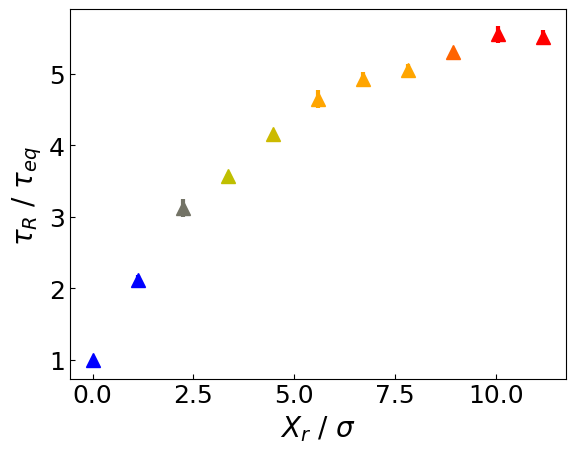

In [32]:
for i, r in enumerate(start_positions):
    plt.errorbar(-1*start_positions[i]/typical_length_scale, mean_platue_indices_per_r_boltz[i]/mean_platue_indices_per_r_boltz[0], yerr=std_platue_indices_per_r_boltz[i]/mean_platue_indices_per_r_boltz[0], linestyle='--', marker = '^', lw=3, ms=10, color=colors_normlized[i])
plt.xlabel('$X_r$ / $\\sigma$', fontsize=20)
plt.ylabel('$\\tau_R$ / $\\tau_{eq}$ ', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.show()

In [34]:
resetting_folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
mean_platue_indices_per_r = np.load(resetting_folder+f'/mean_platue_indices_per_K.npy')
std_platue_indices_per_r = np.load(resetting_folder+f'/std_platue_indices_per_K.npy')

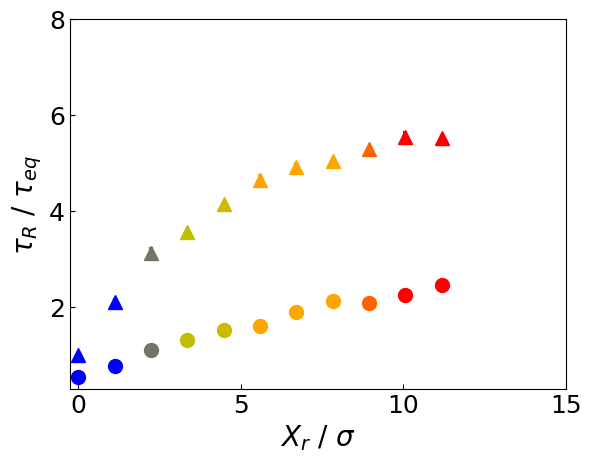

In [36]:
for i, r in enumerate(start_positions):
    plt.errorbar(-1*start_positions[i]/typical_length_scale, mean_platue_indices_per_r_boltz[i]/mean_platue_indices_per_r_boltz[0], yerr=std_platue_indices_per_r_boltz[i]/mean_platue_indices_per_r_boltz[0], linestyle='--', marker = '^', lw=3, ms=10, color=colors_normlized[i])
    plt.errorbar(-1*start_positions[i]/typical_length_scale, mean_platue_indices_per_r[i]/mean_platue_indices_per_r_boltz[0], yerr=std_platue_indices_per_r[i]/mean_platue_indices_per_r_boltz[0], linestyle='--', marker = 'o', lw=3, ms=10, color=colors_normlized[i])
plt.xlabel('$X_r$ / $\\sigma$', fontsize=20)
plt.ylabel('$\\tau_R$ / $\\tau_{eq}$ ', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.xlim(-0.25, 15)
plt.ylim(0.3, 8)
figname = 'c - Relaxation by resetting rate - Harmonic - Boltzmann and resetting.png'
#path = os.path.join('..', 'FasterByResetting-Figures/Figure2',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

In [37]:
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
np.save(folder+f'/mean_platue_indices_per_K_boltz.npy', mean_platue_indices_per_r_boltz)
np.save(folder+f'/std_platue_indices_per_K_boltz.npy', std_platue_indices_per_r_boltz)
np.save(folder+f'/start_positions.npy', -1*start_positions/typical_length_scale)

In [38]:
folder = f'HarmonicPotentialTrajectories/x_0_r_0-{start_positions_str}'
mean_platue_indices_per_r_boltz = np.load(folder+f'/mean_platue_indices_per_K_boltz.npy')
std_platue_indices_per_r_boltz = np.load(folder+f'/std_platue_indices_per_K_boltz.npy')